# <font color='#4C5FDA'>**Breast Cancer Detection Based on CNNs Using Thermal Imaging** </font>

Original paper by Juan Pablo Zuluaga, Zeina Al Masry, Khaled Benaggoune, Safa Meraghni & Noureddine Zerhouni: [A CNN-based methodology for breast cancer diagnosis using thermal images](https://www.tandfonline.com/doi/full/10.1080/21681163.2020.1824685)

In [35]:
#@title **Importamos librerías necesarias**

# Pytorch essentials
import torch
import torch.nn as nn
import torch.nn.functional as F

# PyTorch torchvision
from torchvision.transforms import v2

# Pytorch essentials for datasets.
from torch.utils.data import Dataset, DataLoader, ConcatDataset

# Data manipulation
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

# Utils
from tqdm import tqdm
from datetime import datetime

## <font color='#ECA702'>**Configuración inicial para conectarnos con Kaggle**</font>

1. Instalamos kaggle. Para poder usar comandos de Kaggle.

In [2]:
! pip install kaggle

Subimos nuestro token de autenticación de Kaggle (si estamos en colab, sino colocarlo en la carpeta del proyecto)

In [ ]:
from google.colab import files
files.upload()

1. Creamos los directorios de Kaggle
2. Copiamos nuestro token en .kaggle
3. Con `chmod 600` establecemos los permitos del token en 600, es decir, que solo yo tengo permisos de lectura y escritura sobre el archivo

In [3]:
! mkdir ~/kaggle

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

## <font color='#ECA702'>**Procesamiento del dataset**</font>

### <font color='#52F17F'>**Carga del dataset**</font>

Traemos el dataset [Thermal Images for Breast Cancer Diagnosis DMR-IR](https://www.kaggle.com/datasets/asdeepak/thermal-images-for-breast-cancer-diagnosis-dmrir) desde kaggle.

This dataset is a methodology for breast disease computer-aided diagnosis using dynamic thermography. The thermal images for breast tumors are classified according to DMR-IR standards.

Two types of tumors are classified in this dataset one is benign another is malignant.
- Benign: This type of tumor is usually well-defined and round or oval in shape. (non-cancerous tumor)
- Malignant: This type of tumor is usually poorly defined and irregular with lobules. (cancerous tumor)

In [ ]:
! kaggle datasets download -d asdeepak/thermal-images-for-breast-cancer-diagnosis-dmrir
! unzip thermal-images-for-breast-cancer-diagnosis-dmrir.zip

Después de descargar los datos. Debemos entender la estructura de las carpetas para poder trabajar con ellas de una mejor manera.
1. La carpeta principal `Imagens e Matrizes da Tese de Thiago Alves Elias da Silva` son todos los datos `data`.
2. La carpeta `12 Novos Casos de Testes` la podemos tomar como nuestro conjunto de prueba (`test`).
3. Mientras que la carpeta `Desenvolvimento da Metodologia` será nuestro conjunto de entrenamiento (`train`).

Luego dentro de nuestras carpetas de `train` y `test` encontramos dos categorías `DOENTES`y `SAUDAтХа├╝VEIS` o SAUDÁVEI. Los primeros son los casos malignos y los segundos benignos.

Dentro de cada una de las carpetas de pacientes saludables y enfermos se encuentran carpetas con números, cada número representa un paciente. Y para cada paciente tendremos dos carpetas más, una para las imágenes **segmentadas** en escala de grises y la otra para la matrix o mapa de calor.

Algo bueno de este dataset es que ya está dividido por pacientes, es decir, no tendremos imagenes del mismo paciente en el conjunto de entrenamiento y testeo. Por lo tanto, vamos a entrenar con N pacientes, y testear con K pacientes, que no son los mismos.

### <font color='#52F17F'>**Preprocesamiento de los datos**</font>

#### <font color="6600CC">**Ejemplo con un sample**</font>

In [12]:
matrix = np.loadtxt("Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/DOENTES/256/Matrizes/PAC_62_DN0.txt", dtype=np.float32)
print(matrix.shape)
print(matrix.max(), matrix.min())

(480, 640)
36.22 21.07


In [7]:
matrix = np.loadtxt("Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/DOENTES/256/Matrizes/PAC_62_DN1.txt", dtype=np.float32)
print(matrix.shape)
print(matrix.max(), matrix.min())

(480, 640)
35.98 21.05


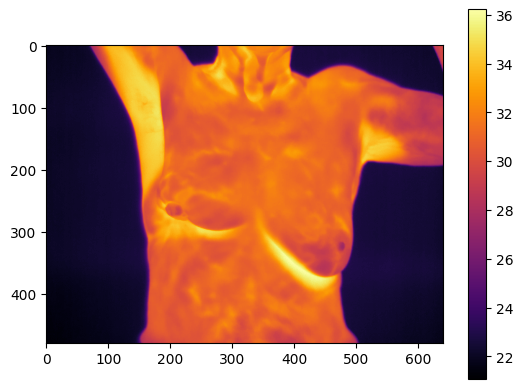

In [30]:
plt.imshow(matrix, cmap="inferno")
plt.colorbar()
plt.show()

In [14]:
img_gray = cv2.imread("Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/DOENTES/256/Segmentadas/PAC_62_DN0-dir.png", cv2.IMREAD_GRAYSCALE)
print(img_gray.shape, img_gray.dtype)

(480, 640) uint8


In [17]:
segmented = np.where(img_gray==0, 0, 1)
segmented = matrix * segmented
print(segmented.shape, segmented.dtype)

(480, 640) float64


In [19]:
segmented.min()

0.0

In [20]:
segmented.max()

34.27000045776367

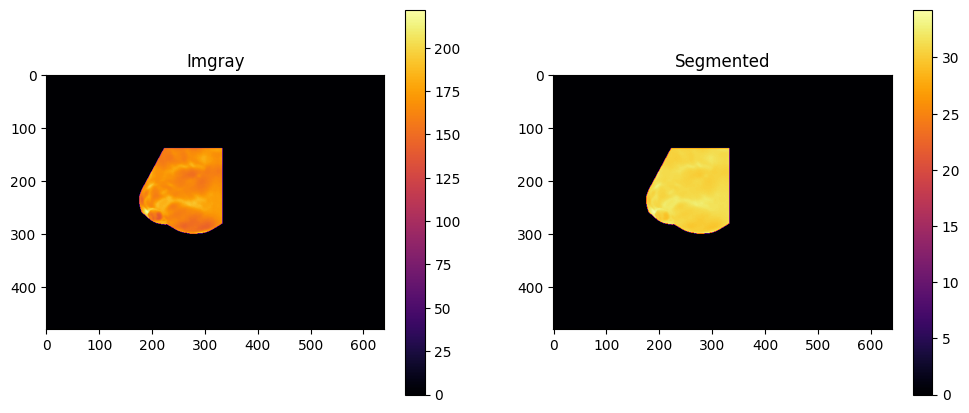

In [32]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title("Imgray")
plt.imshow(img_gray, cmap="inferno")
plt.colorbar()
plt.subplot(122)
plt.title("Segmented")
plt.imshow(segmented, cmap="inferno")
plt.colorbar()
plt.show()

!!! https://stackoverflow.com/questions/44409981/how-to-convert-between-different-color-maps-on-opencv

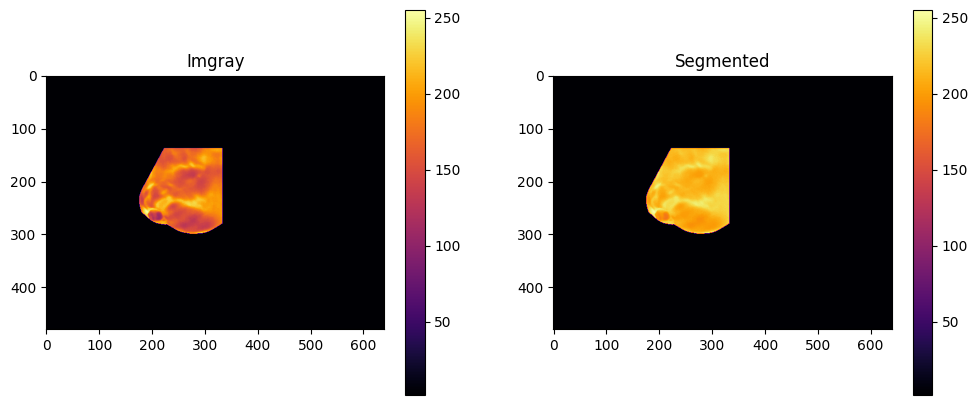

In [35]:
# Create an object for executing CLAHE.
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

""" Para la imgray """

# Normalizing frame to range [0, 255], and get the result as type uint8.
normed = cv2.normalize(img_gray, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
# Apply CLAHE - contrast enhancement.
cl1 = clahe.apply(normed)

""" Para la segmented """

# Normalizing frame to range [0, 255], and get the result as type uint8.
normed = cv2.normalize(segmented, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
# Apply CLAHE - contrast enhancement.
cl2 = clahe.apply(normed)

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title("Imgray")
plt.imshow(cl1, cmap="inferno")
plt.colorbar()
plt.subplot(122)
plt.title("Segmented")
plt.imshow(cl2, cmap="inferno")
plt.colorbar()
plt.show()

#### <font color="6600CC">**Generando mapa de color**</font>

Considero que no es necesario aplicarlo a todas las imágenes. Solo a las de presentación.

https://stackoverflow.com/questions/66909370/thermal-image-processing

In [ ]:
colormap_rainbow = [1, 3, 74, 0, 3, 74, 0, 3, 75, 0, 3, 75, 0, 3, 76, 0, 3, 76, 0, 3, 77, 0, 3, 79, 0, 3, 82, 0, 5, 85, 0, 7, 88, 0, 10, 91, 0, 14, 94, 0, 19, 98, 0, 22, 100, 0, 25, 103, 0, 28, 106, 0, 32, 109, 0, 35, 112, 0, 38, 116, 0, 40, 119, 0, 42, 123, 0, 45, 128, 0, 49, 133, 0, 50, 134, 0, 51, 136, 0, 52, 137, 0, 53, 139, 0, 54, 142, 0, 55, 144, 0, 56, 145, 0, 58, 149, 0, 61, 154, 0, 63, 156, 0, 65, 159, 0, 66, 161, 0, 68, 164, 0, 69, 167, 0, 71, 170, 0, 73, 174, 0, 75, 179, 0, 76, 181, 0, 78, 184, 0, 79, 187, 0, 80, 188, 0, 81, 190, 0, 84, 194, 0, 87, 198, 0, 88, 200, 0, 90, 203, 0, 92, 205, 0, 94, 207, 0, 94, 208, 0, 95, 209, 0, 96, 210, 0, 97, 211, 0, 99, 214, 0, 102, 217, 0, 103, 218, 0, 104, 219, 0, 105, 220, 0, 107, 221, 0, 109, 223, 0, 111, 223, 0, 113, 223, 0, 115, 222, 0, 117, 221, 0, 118, 220, 1, 120, 219, 1, 122, 217, 2, 124, 216, 2, 126, 214, 3, 129, 212, 3, 131, 207, 4, 132, 205, 4, 133, 202, 4, 134, 197, 5, 136, 192, 6, 138, 185, 7, 141, 178, 8, 142, 172, 10, 144, 166, 10, 144, 162, 11, 145, 158, 12, 146, 153, 13, 147, 149, 15, 149, 140, 17, 151, 132, 22, 153, 120, 25, 154, 115, 28, 156, 109, 34, 158, 101, 40, 160, 94, 45, 162, 86, 51, 164, 79, 59, 167, 69, 67, 171, 60, 72, 173, 54, 78, 175, 48, 83, 177, 43, 89, 179, 39, 93, 181, 35, 98, 183, 31, 105, 185, 26, 109, 187, 23, 113, 188, 21, 118, 189, 19, 123, 191, 17, 128, 193, 14, 134, 195, 12, 138, 196, 10, 142, 197, 8, 146, 198, 6, 151, 200, 5, 155, 201, 4, 160, 203, 3, 164, 204, 2, 169, 205, 2, 173, 206, 1, 175, 207, 1, 178, 207, 1, 184, 208, 0, 190, 210, 0, 193, 211, 0, 196, 212, 0, 199, 212, 0, 202, 213, 1, 207, 214, 2, 212, 215, 3, 215, 214, 3, 218, 214, 3, 220, 213, 3, 222, 213, 4, 224, 212, 4, 225, 212, 5, 226, 212, 5, 229, 211, 5, 232, 211, 6, 232, 211, 6, 233, 211, 6, 234, 210, 6, 235, 210, 7, 236, 209, 7, 237, 208, 8, 239, 206, 8, 241, 204, 9, 242, 203, 9, 244, 202, 10, 244, 201, 10, 245, 200, 10, 245, 199, 11, 246, 198, 11, 247, 197, 12, 248, 194, 13, 249, 191, 14, 250, 189, 14, 251, 187, 15, 251, 185, 16, 252, 183, 17, 252, 178, 18, 253, 174, 19, 253, 171, 19, 254, 168, 20, 254, 165, 21, 254, 164, 21, 255, 163, 22, 255, 161, 22, 255, 159, 23, 255, 157, 23, 255, 155, 24, 255, 149, 25, 255, 143, 27, 255, 139, 28, 255, 135, 30, 255, 131, 31, 255, 127, 32, 255, 118, 34, 255, 110, 36, 255, 104, 37, 255, 101, 38, 255, 99, 39, 255, 93, 40, 255, 88, 42, 254, 82, 43, 254, 77, 45, 254, 69, 47, 254, 62, 49, 253, 57, 50, 253, 53, 52, 252, 49, 53, 252, 45, 55, 251, 39, 57, 251, 33, 59, 251, 32, 60, 251, 31, 60, 251, 30, 61, 251, 29, 61, 251, 28, 62, 250, 27, 63, 250, 27, 65, 249, 26, 66, 249, 26, 68, 248, 25, 70, 248, 24, 73, 247, 24, 75, 247, 25, 77, 247, 25, 79, 247, 26, 81, 247, 32, 83, 247, 35, 85, 247, 38, 86, 247, 42, 88, 247, 46, 90, 247, 50, 92, 248, 55, 94, 248, 59, 96, 248, 64, 98, 248, 72, 101, 249, 81, 104, 249, 87, 106, 250, 93, 108, 250, 95, 109, 250, 98, 110, 250, 100, 111, 251, 101, 112, 251, 102, 113, 251, 109, 117, 252, 116, 121, 252, 121, 123, 253, 126, 126, 253, 130, 128, 254, 135, 131, 254, 139, 133, 254, 144, 136, 254, 151, 140, 255, 158, 144, 255, 163, 146, 255, 168, 149, 255, 173, 152, 255, 176, 153, 255, 178, 155, 255, 184, 160, 255, 191, 165, 255, 195, 168, 255, 199, 172, 255, 203, 175, 255, 207, 179, 255, 211, 182, 255, 216, 185, 255, 218, 190, 255, 220, 196, 255, 222, 200, 255, 225, 202, 255, 227, 204, 255, 230, 206, 255, 233, 208]
colormap_grayscale = [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17, 18, 18, 18, 19, 19, 19, 20, 20, 20, 21, 21, 21, 22, 22, 22, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 26, 27, 27, 27, 28, 28, 28, 29, 29, 29, 30, 30, 30, 31, 31, 31, 32, 32, 32, 33, 33, 33, 34, 34, 34, 35, 35, 35, 36, 36, 36, 37, 37, 37, 38, 38, 38, 39, 39, 39, 40, 40, 40, 41, 41, 41, 42, 42, 42, 43, 43, 43, 44, 44, 44, 45, 45, 45, 46, 46, 46, 47, 47, 47, 48, 48, 48, 49, 49, 49, 50, 50, 50, 51, 51, 51, 52, 52, 52, 53, 53, 53, 54, 54, 54, 55, 55, 55, 56, 56, 56, 57, 57, 57, 58, 58, 58, 59, 59, 59, 60, 60, 60, 61, 61, 61, 62, 62, 62, 63, 63, 63, 64, 64, 64, 65, 65, 65, 66, 66, 66, 67, 67, 67, 68, 68, 68, 69, 69, 69, 70, 70, 70, 71, 71, 71, 72, 72, 72, 73, 73, 73, 74, 74, 74, 75, 75, 75, 76, 76, 76, 77, 77, 77, 78, 78, 78, 79, 79, 79, 80, 80, 80, 81, 81, 81, 82, 82, 82, 83, 83, 83, 84, 84, 84, 85, 85, 85, 86, 86, 86, 87, 87, 87, 88, 88, 88, 89, 89, 89, 90, 90, 90, 91, 91, 91, 92, 92, 92, 93, 93, 93, 94, 94, 94, 95, 95, 95, 96, 96, 96, 97, 97, 97, 98, 98, 98, 99, 99, 99, 100, 100, 100, 101, 101, 101, 102, 102, 102, 103, 103, 103, 104, 104, 104, 105, 105, 105, 106, 106, 106, 107, 107, 107, 108, 108, 108, 109, 109, 109, 110, 110, 110, 111, 111, 111, 112, 112, 112, 113, 113, 113, 114, 114, 114, 115, 115, 115, 116, 116, 116, 117, 117, 117, 118, 118, 118, 119, 119, 119, 120, 120, 120, 121, 121, 121, 122, 122, 122, 123, 123, 123, 124, 124, 124, 125, 125, 125, 126, 126, 126, 127, 127, 127, 128, 128, 128, 129, 129, 129, 130, 130, 130, 131, 131, 131, 132, 132, 132, 133, 133, 133, 134, 134, 134, 135, 135, 135, 136, 136, 136, 137, 137, 137, 138, 138, 138, 139, 139, 139, 140, 140, 140, 141, 141, 141, 142, 142, 142, 143, 143, 143, 144, 144, 144, 145, 145, 145, 146, 146, 146, 147, 147, 147, 148, 148, 148, 149, 149, 149, 150, 150, 150, 151, 151, 151, 152, 152, 152, 153, 153, 153, 154, 154, 154, 155, 155, 155, 156, 156, 156, 157, 157, 157, 158, 158, 158, 159, 159, 159, 160, 160, 160, 161, 161, 161, 162, 162, 162, 163, 163, 163, 164, 164, 164, 165, 165, 165, 166, 166, 166, 167, 167, 167, 168, 168, 168, 169, 169, 169, 170, 170, 170, 171, 171, 171, 172, 172, 172, 173, 173, 173, 174, 174, 174, 175, 175, 175, 176, 176, 176, 177, 177, 177, 178, 178, 178, 179, 179, 179, 180, 180, 180, 181, 181, 181, 182, 182, 182, 183, 183, 183, 184, 184, 184, 185, 185, 185, 186, 186, 186, 187, 187, 187, 188, 188, 188, 189, 189, 189, 190, 190, 190, 191, 191, 191, 192, 192, 192, 193, 193, 193, 194, 194, 194, 195, 195, 195, 196, 196, 196, 197, 197, 197, 198, 198, 198, 199, 199, 199, 200, 200, 200, 201, 201, 201, 202, 202, 202, 203, 203, 203, 204, 204, 204, 205, 205, 205, 206, 206, 206, 207, 207, 207, 208, 208, 208, 209, 209, 209, 210, 210, 210, 211, 211, 211, 212, 212, 212, 213, 213, 213, 214, 214, 214, 215, 215, 215, 216, 216, 216, 217, 217, 217, 218, 218, 218, 219, 219, 219, 220, 220, 220, 221, 221, 221, 222, 222, 222, 223, 223, 223, 224, 224, 224, 225, 225, 225, 226, 226, 226, 227, 227, 227, 228, 228, 228, 229, 229, 229, 230, 230, 230, 231, 231, 231, 232, 232, 232, 233, 233, 233, 234, 234, 234, 235, 235, 235, 236, 236, 236, 237, 237, 237, 238, 238, 238, 239, 239, 239, 240, 240, 240, 241, 241, 241, 242, 242, 242, 243, 243, 243, 244, 244, 244, 245, 245, 245, 246, 246, 246, 247, 247, 247, 248, 248, 248, 249, 249, 249, 250, 250, 250, 251, 251, 251, 252, 252, 252, 253, 253, 253, 254, 254, 254, 255, 255, 255]
colormap_ironblack = [255, 255, 255, 253, 253, 253, 251, 251, 251, 249, 249, 249, 247, 247, 247, 245, 245, 245, 243, 243, 243, 241, 241, 241, 239, 239, 239, 237, 237, 237, 235, 235, 235, 233, 233, 233, 231, 231, 231, 229, 229, 229, 227, 227, 227, 225, 225, 225, 223, 223, 223, 221, 221, 221, 219, 219, 219, 217, 217, 217, 215, 215, 215, 213, 213, 213, 211, 211, 211, 209, 209, 209, 207, 207, 207, 205, 205, 205, 203, 203, 203, 201, 201, 201, 199, 199, 199, 197, 197, 197, 195, 195, 195, 193, 193, 193, 191, 191, 191, 189, 189, 189, 187, 187, 187, 185, 185, 185, 183, 183, 183, 181, 181, 181, 179, 179, 179, 177, 177, 177, 175, 175, 175, 173, 173, 173, 171, 171, 171, 169, 169, 169, 167, 167, 167, 165, 165, 165, 163, 163, 163, 161, 161, 161, 159, 159, 159, 157, 157, 157, 155, 155, 155, 153, 153, 153, 151, 151, 151, 149, 149, 149, 147, 147, 147, 145, 145, 145, 143, 143, 143, 141, 141, 141, 139, 139, 139, 137, 137, 137, 135, 135, 135, 133, 133, 133, 131, 131, 131, 129, 129, 129, 126, 126, 126, 124, 124, 124, 122, 122, 122, 120, 120, 120, 118, 118, 118, 116, 116, 116, 114, 114, 114, 112, 112, 112, 110, 110, 110, 108, 108, 108, 106, 106, 106, 104, 104, 104, 102, 102, 102, 100, 100, 100, 98, 98, 98, 96, 96, 96, 94, 94, 94, 92, 92, 92, 90, 90, 90, 88, 88, 88, 86, 86, 86, 84, 84, 84, 82, 82, 82, 80, 80, 80, 78, 78, 78, 76, 76, 76, 74, 74, 74, 72, 72, 72, 70, 70, 70, 68, 68, 68, 66, 66, 66, 64, 64, 64, 62, 62, 62, 60, 60, 60, 58, 58, 58, 56, 56, 56, 54, 54, 54, 52, 52, 52, 50, 50, 50, 48, 48, 48, 46, 46, 46, 44, 44, 44, 42, 42, 42, 40, 40, 40, 38, 38, 38, 36, 36, 36, 34, 34, 34, 32, 32, 32, 30, 30, 30, 28, 28, 28, 26, 26, 26, 24, 24, 24, 22, 22, 22, 20, 20, 20, 18, 18, 18, 16, 16, 16, 14, 14, 14, 12, 12, 12, 10, 10, 10, 8, 8, 8, 6, 6, 6, 4, 4, 4, 2, 2, 2, 0, 0, 0, 0, 0, 9, 2, 0, 16, 4, 0, 24, 6, 0, 31, 8, 0, 38, 10, 0, 45, 12, 0, 53, 14, 0, 60, 17, 0, 67, 19, 0, 74, 21, 0, 82, 23, 0, 89, 25, 0, 96, 27, 0, 103, 29, 0, 111, 31, 0, 118, 36, 0, 120, 41, 0, 121, 46, 0, 122, 51, 0, 123, 56, 0, 124, 61, 0, 125, 66, 0, 126, 71, 0, 127, 76, 1, 128, 81, 1, 129, 86, 1, 130, 91, 1, 131, 96, 1, 132, 101, 1, 133, 106, 1, 134, 111, 1, 135, 116, 1, 136, 121, 1, 136, 125, 2, 137, 130, 2, 137, 135, 3, 137, 139, 3, 138, 144, 3, 138, 149, 4, 138, 153, 4, 139, 158, 5, 139, 163, 5, 139, 167, 5, 140, 172, 6, 140, 177, 6, 140, 181, 7, 141, 186, 7, 141, 189, 10, 137, 191, 13, 132, 194, 16, 127, 196, 19, 121, 198, 22, 116, 200, 25, 111, 203, 28, 106, 205, 31, 101, 207, 34, 95, 209, 37, 90, 212, 40, 85, 214, 43, 80, 216, 46, 75, 218, 49, 69, 221, 52, 64, 223, 55, 59, 224, 57, 49, 225, 60, 47, 226, 64, 44, 227, 67, 42, 228, 71, 39, 229, 74, 37, 230, 78, 34, 231, 81, 32, 231, 85, 29, 232, 88, 27, 233, 92, 24, 234, 95, 22, 235, 99, 19, 236, 102, 17, 237, 106, 14, 238, 109, 12, 239, 112, 12, 240, 116, 12, 240, 119, 12, 241, 123, 12, 241, 127, 12, 242, 130, 12, 242, 134, 12, 243, 138, 12, 243, 141, 13, 244, 145, 13, 244, 149, 13, 245, 152, 13, 245, 156, 13, 246, 160, 13, 246, 163, 13, 247, 167, 13, 247, 171, 13, 248, 175, 14, 248, 178, 15, 249, 182, 16, 249, 185, 18, 250, 189, 19, 250, 192, 20, 251, 196, 21, 251, 199, 22, 252, 203, 23, 252, 206, 24, 253, 210, 25, 253, 213, 27, 254, 217, 28, 254, 220, 29, 255, 224, 30, 255, 227, 39, 255, 229, 53, 255, 231, 67, 255, 233, 81, 255, 234, 95, 255, 236, 109, 255, 238, 123, 255, 240, 137, 255, 242, 151, 255, 244, 165, 255, 246, 179, 255, 248, 193, 255, 249, 207, 255, 251, 221, 255, 253, 235, 255, 255, 24]

In [ ]:
def generateColourMap(colormap=colormap_ironblack):
  """
  Conversion of the colour map from GetThermal to a numpy LUT:
      https://github.com/groupgets/GetThermal/blob/bb467924750a686cc3930f7e3a253818b755a2c0/src/dataformatter.cpp#L6
  """
  lut = np.zeros((256, 1, 3), dtype=np.uint8)

  def colormapChunk(ulist, step):
    return map(lambda i: ulist[i: i + step], range(0, len(ulist), step))

  chunks = colormapChunk(colormap, 3)

  red = []
  green = []
  blue = []

  for chunk in chunks:
      red.append(chunk[0])
      green.append(chunk[1])
      blue.append(chunk[2])

  lut[:, 0, 0] = blue
  lut[:, 0, 1] = green
  lut[:, 0, 2] = red

  return lut

In [ ]:
# Normalizing frame to range [0, 255], and get the result as type uint8.
normed = cv2.normalize(matrix, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
# Apply CLAHE - contrast enhancement.
cl3 = clahe.apply(normed)
nor = cv2.cvtColor(cl3, cv2.COLOR_GRAY2BGR)  # Convert gray-scale to BGR (no really needed).
print(nor.shape, nor.dtype)

(480, 640, 3) uint8


In [ ]:
colorMap_rainbow = generateColourMap(colormap_rainbow)
colorMap_ironblack = generateColourMap(colormap_ironblack)
# colorMap_grayscale = generateColourMap(colormap_grayscale)

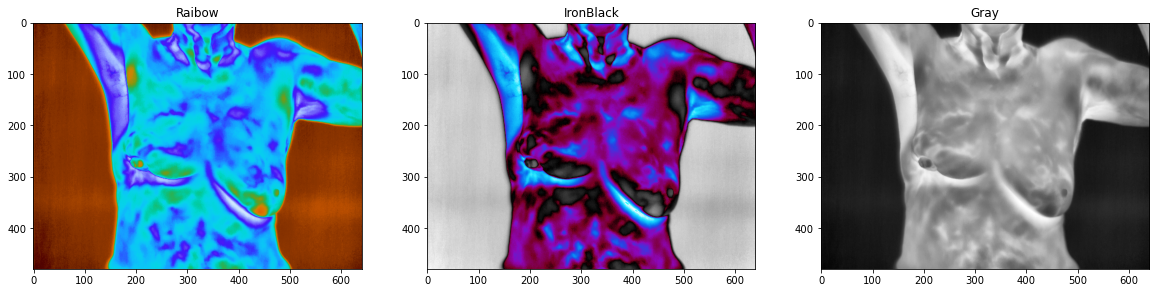

In [ ]:
colorized_img_rw = cv2.LUT(nor, colorMap_rainbow)  # Colorize the gray image with "false colors".
colorized_img_ib = cv2.LUT(nor, colorMap_ironblack)  # Colorize the gray image with "false colors".

plt.figure(figsize=(20,6))
plt.subplot(131)
plt.title("Raibow")
plt.imshow(colorized_img_rw)
plt.subplot(132)
plt.title("IronBlack")
plt.imshow(colorized_img_ib)
plt.subplot(133)
plt.title("Gray")
plt.imshow(nor)
plt.show()

#### <font color="6600CC">**Detalle con las imágenes segmentadas**</font>

In [165]:
# La primera la lee en RGB, pero la original viene con 4 canales
img_der = cv2.imread("Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/DOENTES/256/Segmentadas/PAC_62_DN0-dir.png")

# # https://stackoverflow.com/questions/3803888/how-to-load-png-images-with-4-channels
img_original = cv2.imread("Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/DOENTES/256/Segmentadas/PAC_62_DN0-dir.png", cv2.IMREAD_UNCHANGED)

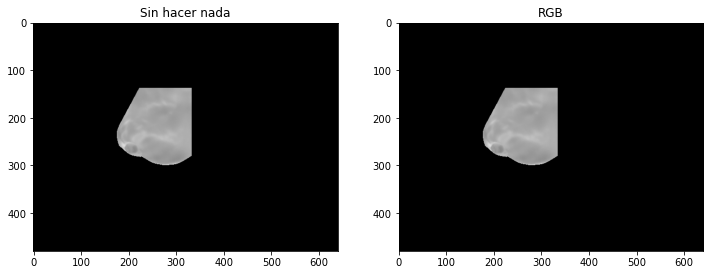

In [166]:
plt.figure(figsize=(12,9))
plt.subplot(121)
plt.title("Sin hacer nada")
plt.imshow(img_original)
plt.subplot(122)
plt.title("RGB")
plt.imshow(img_der)
plt.show()

¿Por qué las segmentadas vienen en 4 canales? ¿Cómo interpretar el cuarto canal?

In [167]:
img_original[:, :, 3]

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

### <font color='#52F17F'>**Creación del Dataset PyTorch**</font>

¿Qué es?: https://youtu.be/jF43_wj_DCQ?list=PL_lsbAsL_o2CTlGHgMxNrKhzP97BaG9ZN&t=53

In [2]:
class ThermalDataset(Dataset):
  def __init__(self, image_dir: str, matrix_dir: str, transform = None):
    self.image_dir = image_dir
    self.matrix_dir = matrix_dir
    self.transform = transform
    self.images = os.listdir(image_dir) # Listamos todas las imagenes en la carpeta

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):

    """ Carga de la imagen """

    # Entramos a la carpeta y conseguimos la imagen de la lista
    img_path = os.path.join(self.image_dir, self.images[index])

    # Leemos la imagen segmentada en escala de grises
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # uint8

    """ Carga de la matrix """

    # Entramos a la carpeta y conseguimos la matrix de la lista.
      # La razon por la que uso la misma lista de imagenes es porque la imagen y la matrix
      # tienen el mismo nombre, solo cambia la ruta de la carpeta y la extensión.
    """ matrizes: Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/DOENTES/256/Matrizes/PAC_62_DN0.txt """
    """ segmentada: Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes/DOENTES/256/Segmentadas/PAC_62_DN0-dir.png """
    
    if '-dir.png' in self.images[index]:
      matrix_path = os.path.join(self.matrix_dir, self.images[index].replace("-dir.png", ".txt"))
    elif '-esq.png' in self.images[index]:
      matrix_path = os.path.join(self.matrix_dir, self.images[index].replace("-esq.png", ".txt"))
      
    matrix = np.loadtxt(matrix_path, dtype=np.float32) # https://www.geeksforgeeks.org/import-text-files-into-numpy-arrays/

    """ Consigo la imagen segmentada con los valores de la matrix """

    segmented = np.where(img==0, 0, 1) # int64
    # segmented = img * matrix
    img = (matrix * segmented).astype(np.float32) # float32, shape (480, 640)

    # Le agrego un canal explícito 
    img = np.expand_dims(img, axis=2) # https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html

    # img = img / 255.
    # Create an object for executing CLAHE.
    # clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    # Normalizing frame to range [0, 255], and get the result as type uint8.
    # normed = cv2.normalize(segmented, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    # img = clahe.apply(normed)

    """ Consiguiendo el label """

    # Para conseguir la etiqueta simplemente me tengo que fijar en la ruta. Si es 'DOENTES' 1
    # sino 0.

    label = self.image_dir.split('/')[2]
    if label == 'DOENTES':
      label = 1
    else:
      label = 0

    """ Convertir las imagenes en tensores y hacer resize """
    if self.transform:
      # Aplicamos las transformaciones a la imagen
      # print(type(img), img.shape)
      img = self.transform(img)
      
    return img, label

In [3]:
TEST_PATH = "Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/12 Novos Casos de Testes"
TRAIN_PATH = "Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia"

In [4]:
# Primero consigo la ruta de imagenes y matrices para cada uno de los pacientes

dirs_test = []
test_images = 0
test_matrices = 0
for category in os.listdir(TEST_PATH):
  # print(category)
  for patient in os.listdir(os.path.join(TEST_PATH, category)):
    # print(os.path.join(TEST_PATH, category, patient))
    dirs_test.append(os.path.join(TEST_PATH, category, patient))
    _, _, files = next(os.walk(os.path.join(TEST_PATH, category, patient, "Segmentadas")))
    # print(files)
    test_images += len(files)
    _, _, files = next(os.walk(os.path.join(TEST_PATH, category, patient, "Matrizes")))
    test_matrices += len(files)


dirs_train = []
train_images = 0
train_matrices = 0
for category in os.listdir(TRAIN_PATH):
  # print(category)
  for patient in os.listdir(os.path.join(TRAIN_PATH, category)):
    # print(os.path.join(TRAIN_PATH, category, patient))
    dirs_train.append(os.path.join(TRAIN_PATH, category, patient))
    _, _, files = next(os.walk(os.path.join(TRAIN_PATH, category, patient, "Segmentadas")))
    train_images += len(files)
    try:
      _, _, files = next(os.walk(os.path.join(TRAIN_PATH, category, patient, "Matrizes")))
      train_matrices += len(files)
    except:
      _, _, files = next(os.walk(os.path.join(TRAIN_PATH, category, patient, "Matrizes de Temperatura")))
      train_matrices += len(files)



# Imprimo la cantidad de pacientes y datos que tenemos
print(f"Cantidad de pacientes para testeo: {len(dirs_test)}")
print(f"Cantidad de imagenes para testeo: {test_images}")
print(f"Cantidad de matrices para testeo: {test_matrices}")
print()
print(f"Cantidad de pacientes para entrenamiento: {len(dirs_train)}")
print(f"Cantidad de imagenes para entrenamiento: {train_images}")
print(f"Cantidad de matrices para entrenamiento: {train_matrices}")

Cantidad de pacientes para testeo: 9
Cantidad de imagenes para testeo: 240
Cantidad de matrices para testeo: 180

Cantidad de pacientes para entrenamiento: 47
Cantidad de imagenes para entrenamiento: 1282
Cantidad de matrices para entrenamiento: 948


En teoría por cada paciente tenemos 20 imagenes, pero las cuentas no cuadran, por ejemplo en testeo deberíamos tener 9x20 = 180 imagenes, pero aparecen 240. Esto sucede debido a que hay algunas imagenes que están separadas en la parte izquierda y derecha.

Para el conjunto de entrenamiento tampoco cuadra el número de matrices. Esto es debido a que algunos pacientes tienen una matriz que se llama `ESTATICO` que no tengo ni idea para qué es pero no es problema ya que no hace 'match' con ninguna imágen.

In [177]:
matrix = np.loadtxt("Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia/DOENTES/245/Matrizes/PAC_26_ESTATICO.txt", dtype=np.float32)
print(matrix.shape)
print(matrix.max(), matrix.min())

(480, 640)
35.02 20.38


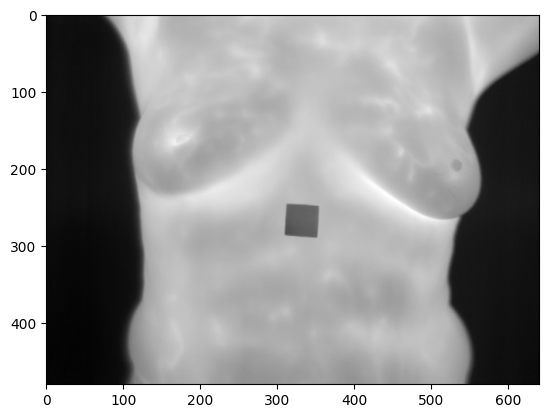

In [178]:
plt.imshow(matrix, cmap='gray')
plt.show()

In [5]:
# Todas las imagenes vienen en h: 480, w: 640. El objetivo es disminuir el tamaño
# sin perder la relación de aspecto. https://gist.github.com/tomvon/ae288482869b495201a0

HEIGHT = 300
r = HEIGHT/480 # Calculo la relación de aspecto. 
WIDTH = int(640*r)
print(f"Las imagenes son reescaladas a {HEIGHT}x{WIDTH}")

# https://pytorch.org/vision/main/transforms.html#performance-considerations
transform = v2.Compose([  
    v2.ToImage(), 
    v2.Resize(size=(HEIGHT, WIDTH), antialias=True), 
    # v2.ToDtype(torch.float32),
    #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Las imagenes son reescaladas a 300x400


Para cada paciente armo un dataset y luego con `ConcatDataset` junto todos los pacientes para entrenamiento y para testeo.

In [6]:
test_datasets = []
for patient in dirs_test:
  folders = sorted(os.listdir(patient))
  # print(folders)
  test_datasets.append(ThermalDataset(f"{patient}/{folders[1]}", f"{patient}/{folders[0]}", transform=transform))

In [7]:
train_datasets = []
for patient in dirs_train:
  folders = sorted(os.listdir(patient))
  # print(folders)
  train_datasets.append(ThermalDataset(f"{patient}/{folders[1]}", f"{patient}/{folders[0]}", transform=transform))

In [8]:
# Datasets (concatenate) https://stackoverflow.com/questions/60840500/pytorch-concatenating-datasets-before-using-dataloader
test_dataset = torch.utils.data.ConcatDataset(test_datasets)
train_dataset = torch.utils.data.ConcatDataset(train_datasets)

In [9]:
print(test_dataset[0][0].shape, type(test_dataset[0][1]))

torch.Size([1, 300, 400]) <class 'int'>


### <font color='#52F17F'>**Visualización de datos**</font>

In [40]:
def visualize_data(dataset, rows=3, cols=3):
    """
    Visualiza aleatoriamente imágenes del dataset junto con sus etiquetas.

    Args:
        dataset (list): Lista de tuplas donde cada tupla contiene una imagen y su etiqueta correspondiente.
                        La imagen es un arreglo numpy y la etiqueta es un entero (0 para Benign, 1 para Malignant).
        rows (int): Número de filas en la cuadrícula de visualización.
        cols (int): Número de columnas en la cuadrícula de visualización.

    Returns:
        None: Muestra una figura con las imágenes y etiquetas del dataset.
    """
    plt.figure(figsize=(20, rows * 4))
    breast_types = {0: 'Benign', 1: 'Malignant'}

    # Seleccionar índices aleatorios del dataset
    indices = np.random.choice(len(dataset), rows * cols, replace=False)

    for i, idx in enumerate(indices, start=1):
        img = dataset[idx][0].squeeze(0) # Extraer la imagen y eliminar dimensiones singleton si es necesario
        label = dataset[idx][1] # Extraer la etiqueta

        # Configurar la posición del subplot
        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap='inferno')
        plt.title(f"{breast_types[label]}")
        plt.colorbar()
    plt.show()

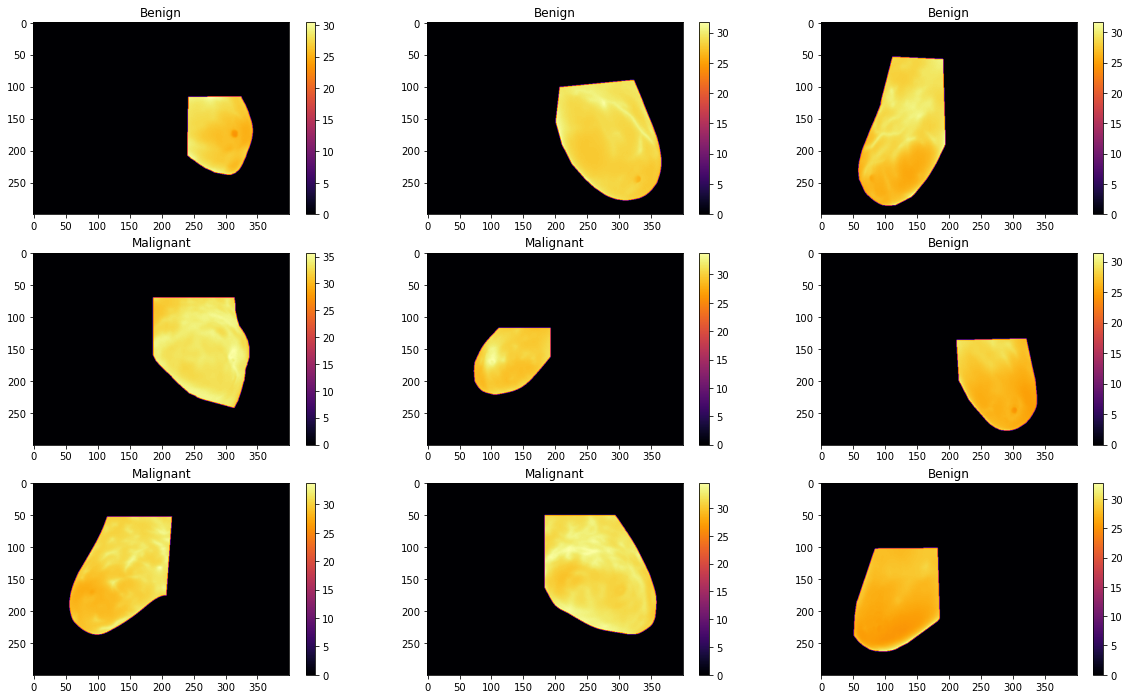

In [42]:
visualize_data(train_dataset)

## <font color='#ECA702'>**Modelo CNN**</font>

### <font color='#52F17F'>**Creando el modelo**</font>

In [10]:
# Este el modelo de ejemplo que usan aquí: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        # Los parametros de esta capa dependen de la salida de la convolución anterior
        self.fc1 = nn.Linear(16 * 72 * 97, 120)
        self.fc2 = nn.Linear(120, 84)

        # El 2 es porque tenemos dos clases y vamos a usar Cross Entropy Loss
        self.fc3 = nn.Linear(84, 2) 
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
# Test al modelo, para ver si nos entrega la salida esperada

input_image = torch.rand((1, 1, 300, 400))
print(f"Entrada: {input_image.size(), {input_image.dtype}}")
model = Net()
ouput = model(input_image)
print(f"Salida: {ouput.size(), ouput.dtype}") # Esperado: [1, 2] (batch 1, 2 clases)

Entrada: (torch.Size([1, 1, 300, 400]), {torch.float32})
Salida: (torch.Size([1, 2]), torch.float32)


In [12]:
# Test al modelo, para ver si nos entrega la salida esperada

input_image = train_dataset[0][0].unsqueeze(0)
print(f"Entrada: {input_image.size(), {input_image.dtype}}")
model = Net()
ouput = model(input_image)
print(f"Salida: {ouput.size(), ouput.dtype}") # Esperado: [1, 2] (batch 1, 2 clases)

Entrada: (torch.Size([1, 1, 300, 400]), {torch.float32})
Salida: (torch.Size([1, 2]), torch.float32)


### <font color='#52F17F'>**Entrenamiento del modelo**</font>

In [13]:
# Hiperparametros
LEARNING_RATE = 1e-4
# Establecemos el tipo de arquitectura que va a entrenar el modelo.
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 4

In [150]:
# Dataloaders
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=True)
print(f'len train: {len(train_loader)}')
print(f'len val: {len(test_loader)}')

len train: 321
len val: 60


In [25]:
""" Parametros del modelo """

# Creacion del modelo y lo movemos a la GPU o CPU
model = Net()
model.to(DEVICE)

# Funcion de perdida (loss)
criterion = nn.CrossEntropyLoss()

# Algoritmos de optimización del gradiente. DESPUÉS de mover el modelo a la GPU.
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [26]:
""" Para guardar datos del modelo cada vez que cambiemos los parametros """

# Se inicializa en una celda separada, así podemos añadir facilmente epocas al mismo run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Crear la carpeta models por si no existe
if os.path.exists('models') == False:
    os.mkdir("models")
    
model_folder_path = f'models/breast_model_{timestamp}'
# model_folder = os.mkdir(model_folder_path)
epoch_number = 0

In [27]:
EPOCHS = 1

for epoch in range(EPOCHS):  # loop over the dataset multiple times
    print(f"EPOCH {epoch_number + 1}")

    running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Movemos los datos al device
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        # print(ouputs.dtype)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 10 mini-batches
            print(f'batch {i + 1:5d} loss: {running_loss / 100:.3f}')
            running_loss = 0.0
    epoch_number += 1 # Pasamos a la siguiente época
print('Finished Training')

EPOCH 1


101it [00:11,  8.60it/s]

batch   100 loss: 0.456


201it [00:23,  8.65it/s]

batch   200 loss: 0.212


301it [00:35,  8.53it/s]

batch   300 loss: 0.130


321it [00:37,  8.49it/s]


EPOCH 2


101it [00:12,  8.20it/s]

batch   100 loss: 0.099


201it [00:25,  8.19it/s]

batch   200 loss: 0.055


301it [00:37,  8.77it/s]

batch   300 loss: 0.069


321it [00:39,  8.05it/s]

Finished Training


### <font color='#52F17F'>**Guardar el modelo**</font>

In [28]:
def save_checkpoint(state, filename=f'model_{timestamp}.pth'):
  print("=> Saving model")
  torch.save(state, filename)
  print("Model saved in", filename)

In [31]:
# Establecemos la ruta donde se va a guardar el estado del modelo
model_path = f"{model_folder_path}_{epoch_number}.pth"

# Guardamos el estado del modelo
checkpoint = {'state_dict': model.state_dict(),
              'optimizer': optimizer.state_dict(),
              'epoch': epoch_number + 1}

save_checkpoint(checkpoint, model_path)

=> Saving model


## <font color='#ECA702'>**Evaluación del modelo**</font>

### <font color='#52F17F'>**Carga un modelo para hacer inferencia o conseguir sus métricas.**</font>

In [32]:
print('=> Loading model')
checkpoint = torch.load("models/breast_model_20240524_093339_3.pth") # Ruta donde está el modelo

# Si el diccionario tiene la clave 'state_dict', significa que NO viene solo el modelo
if 'state_dict' in checkpoint:
  model.load_state_dict(checkpoint['state_dict'])
  print("Modelo cargado exitosamente.")
else:
  # Si viene solo el modelo
  model.load_state_dict(checkpoint)

model.to(DEVICE)
# Apagamos el modo entrenamiento. Es equivalente a model.train(False)
model.eval()
# Para verificar si mi modelo está en modo entrenamiento
if model.training:
    print('El modelo ha sido cargado con training off exitosamente.')

=> Loading model
Modelo cargado exitosamente.


### <font color='#52F17F'>**Display any images from test for inference**</font>

In [145]:
def visualize_images(testloader, rows=3, cols=3):
    """
    Visualiza imágenes de un tensor junto con sus etiquetas.

    Args:
        images (torch.Tensor): Tensor de imágenes de tamaño [N, C, H, W].
        labels (torch.Tensor): Tensor de etiquetas correspondiente a las imágenes.
        rows (int): Número de filas en la cuadrícula de visualización.
        cols (int): Número de columnas en la cuadrícula de visualización.

    Returns:
        None: Muestra una figura con las imágenes y sus etiquetas.
    """

    dataiter = iter(testloader)
    images, labels = next(dataiter)

    plt.figure(figsize=(30, rows * 4))
    breast_types = {0: 'Benign', 1: 'Malignant'}

    # Seleccionar índices aleatorios del tensor
    indices = np.random.choice(images.shape[0], rows * cols, replace=False)

    for i, idx in enumerate(indices, start=1):
        img = images[idx].squeeze(0).numpy()  # Extraer la imagen y eliminar dimensiones singleton si es necesario
        label = labels[idx].item()  # Extraer la etiqueta y convertir a entero

        # Configurar la posición del subplot
        plt.subplot(rows, cols, i)
        plt.imshow(img, cmap='inferno')
        plt.title(f"{breast_types[label]}")
        plt.colorbar()
    plt.show()
    del dataiter
    return images, labels

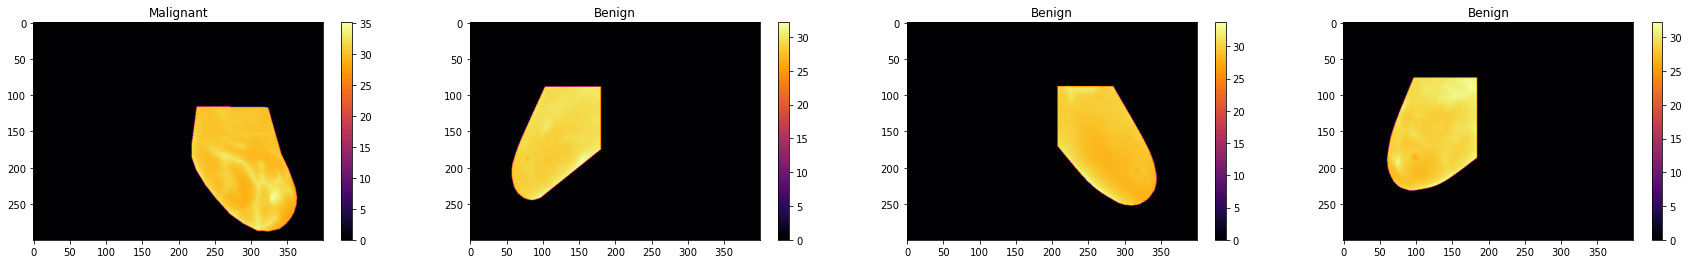

In [153]:
images, labels = visualize_images(test_loader, rows=1, cols=4)

In [154]:
classes = ('Benign', 'Malignant')

images, labels = images.to(DEVICE), labels.to(DEVICE)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted:  Benign Benign Benign Malignant


### <font color='#52F17F'>**Métricas del modelo**</font>

In [155]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {test_images} test images: {100 * correct // total} %')


libpng warning: bKGD: invalid
libpng warning: bKGD: invalid
libpng warning: bKGD: invalid
libpng warning: bKGD: invalid
libpng warning: bKGD: invalid
libpng warning: bKGD: invalid
libpng warning: bKGD: invalid


Accuracy of the network on the 240 test images: 45 %


Ni idea qué sea `libpng warning: bKGD: invalid`.  **Solo pasa con la de test**

**ChatGPT**: Los warnings libpng warning: bKGD: invalid indican que las imágenes que estás utilizando en tu código contienen información de fondo (background) inválida o malformada en sus metadatos. Estos warnings son emitidos por la biblioteca libpng cuando intenta procesar imágenes PNG con campos de metadatos no estándar o incorrectos.

Posibles Soluciones

- Ignorar los Warnings:
Si los warnings no están afectando tu procesamiento, puedes optar por ignorarlos. En muchos casos, estos warnings no impiden que las imágenes se procesen correctamente.

- Limpiar los Metadatos de las Imágenes: Puedes limpiar los metadatos de las imágenes PNG para eliminar cualquier información inválida. ¿Cómo? Convirtiendo las imágenes a otro formato o abriendolas y guardandolas con el mismo formato.